# Neuroimaging Analysis Replication and Prediction Study (NARPS)

Here, we specify the statistical model in the [NARPS](https://www.narps.info/) study using a _BIDS Stats Model_. 

The dataset is publicaly available on [OpenNeuro](https://openneuro.org/datasets/ds001734/).

#### Setup

In [1]:
import json
from pathlib import Path
from itertools import chain

import numpy as np
import pandas as pd

from nilearn.plotting import plot_design_matrix

import bids
from bids.modeling import BIDSStatsModelsGraph
from bids.layout import BIDSLayout

/home/zorro/anaconda3/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


First, we set up the `BIDSLayout` object...

In [2]:
layout = BIDSLayout('./ds001734/')

... and load the _BIDS Stats Model_ JSON specification:

In [3]:
json_file = './model-narps_smdl.json'
spec = json.loads(Path(json_file).read_text())
spec

{'Name': 'NARPS',
 'Description': 'NARPS Analysis model',
 'BIDSModelVersion': '1.0.0',
 'Input': {'task': 'MGT'},
 'Nodes': [{'Level': 'Run',
   'Name': 'run',
   'GroupBy': ['run', 'subject'],
   'Transformations': {'Transformer': 'pybids-transforms-v1',
    'Instructions': [{'Name': 'Threshold',
      'Input': ['gain'],
      'Binarize': True,
      'Output': ['trials']},
     {'Name': 'Scale',
      'Input': ['gain', 'loss', 'RT'],
      'Demean': True,
      'Rescale': False,
      'Output': ['gain', 'loss', 'demeaned_RT']},
     {'Name': 'Convolve',
      'Model': 'spm',
      'Input': ['trials', 'gain', 'loss', 'demeaned_RT']}]},
   'Model': {'X': ['trials', 'gain', 'loss', 'demeaned_RT', 1], 'Type': 'glm'},
   'DummyContrasts': {'Conditions': ['trials', 'gain', 'loss'], 'Test': 't'}},
  {'Level': 'Subject',
   'Name': 'subject',
   'GroupBy': ['subject', 'contrast'],
   'Model': {'X': [1], 'Type': 'meta'},
   'DummyContrasts': {'Test': 't'}},
  {'Level': 'Dataset',
   'Name': '

### Initializing Model

Here, we modify the model to restrict it to a single task and three subjects (for demonstration purposes), and initialize the `BIDSStatsModelGraph` object:

In [4]:
spec['Input'] = {
    'task': 'MGT',
    'subject': ['001', '002', '003']
}

graph = BIDSStatsModelsGraph(layout, spec)

We can visualize the model as a graph:

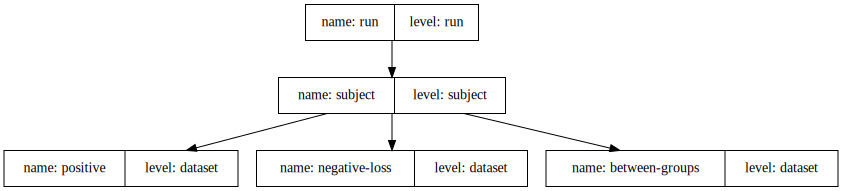

In [5]:
graph.write_graph(format='svg')

This graph specifices that a _run_ level model should be run on every subject / run combination, followed by a _subject_ level model, which combines the results of the _run_ level models.

Finally, at the group level, we have three distinct models: a between-group comparison of the 'loss' contrast, and within-group one-sample t-tests for the 'loss' and 'positive' contrasts.

We'll take a closer look later.

### Populating the Graph

In order to compute the precise design matrices for each level of the model, we need to populate the graph with the specific variables, and outputs from each `Node` to the next.

First, we load the `BIDSVariableCollection` objects, for the entire graph:

In [6]:
try:
    graph.load_collections()
except ValueError:
    graph.load_collections(scan_length=453)  # TR = 1, nvols = 453; necessary if no BOLD data

We can look at the variables available to the root node of the Graph:

In [7]:
root_node = graph.root_node
colls = root_node.get_collections()
colls

[<BIDSRunVariableCollection['RT', 'gain', 'loss', 'participant_response']>,
 <BIDSRunVariableCollection['RT', 'gain', 'loss', 'participant_response']>,
 <BIDSRunVariableCollection['RT', 'gain', 'loss', 'participant_response']>,
 <BIDSRunVariableCollection['RT', 'gain', 'loss', 'participant_response']>,
 <BIDSRunVariableCollection['RT', 'gain', 'loss', 'participant_response']>,
 <BIDSRunVariableCollection['RT', 'gain', 'loss', 'participant_response']>,
 <BIDSRunVariableCollection['RT', 'gain', 'loss', 'participant_response']>,
 <BIDSRunVariableCollection['RT', 'gain', 'loss', 'participant_response']>,
 <BIDSRunVariableCollection['RT', 'gain', 'loss', 'participant_response']>,
 <BIDSRunVariableCollection['RT', 'gain', 'loss', 'participant_response']>,
 <BIDSRunVariableCollection['RT', 'gain', 'loss', 'participant_response']>,
 <BIDSRunVariableCollection['RT', 'gain', 'loss', 'participant_response']>]

In [8]:
root_node.group_by

['run', 'subject']

Note that there are multiple instances of the root node, one for each subject / run combination (the node's `group_by` is : `['run', 'subject']`). We can access the variables for a specific instance of the root node using `variables`:

In [9]:
colls[0].variables

{'gain': <SparseRunVariable(name='gain', source='events')>,
 'loss': <SparseRunVariable(name='loss', source='events')>,
 'RT': <SparseRunVariable(name='RT', source='events')>,
 'participant_response': <SparseRunVariable(name='participant_response', source='events')>}

## Running nodes
Although the graph has defined how `Nodes` and `Edges` are related, it has not yet defined the specific design matrices for each, as this requires knowing the specific variables associated with each `Node`. We can now run the graph to populate the design matrices for each `Node`:

In [10]:
specs = root_node.run(group_by=root_node.group_by, force_dense=False)

/home/zorro/repos/pybids/bids/modeling/statsmodels.py:731: UserWarning: Use 'Contrasts' not 'Conditions' or 'ConditionList' to specifyDummyContrasts. Renaming to 'Contrasts' for now.
  warnings.warn(


For each instance of the root node, a `BIDSStatsModelsNodeOutput` object is created, which contains the model specification, and final design matrix for each:

In [11]:
specs

[<BIDSStatsModelsNodeOutput(level=run, entities={'run': 1, 'subject': '001'})>,
 <BIDSStatsModelsNodeOutput(level=run, entities={'run': 2, 'subject': '001'})>,
 <BIDSStatsModelsNodeOutput(level=run, entities={'run': 3, 'subject': '001'})>,
 <BIDSStatsModelsNodeOutput(level=run, entities={'run': 4, 'subject': '001'})>,
 <BIDSStatsModelsNodeOutput(level=run, entities={'run': 1, 'subject': '002'})>,
 <BIDSStatsModelsNodeOutput(level=run, entities={'run': 2, 'subject': '002'})>,
 <BIDSStatsModelsNodeOutput(level=run, entities={'run': 3, 'subject': '002'})>,
 <BIDSStatsModelsNodeOutput(level=run, entities={'run': 4, 'subject': '002'})>,
 <BIDSStatsModelsNodeOutput(level=run, entities={'run': 1, 'subject': '003'})>,
 <BIDSStatsModelsNodeOutput(level=run, entities={'run': 2, 'subject': '003'})>,
 <BIDSStatsModelsNodeOutput(level=run, entities={'run': 3, 'subject': '003'})>,
 <BIDSStatsModelsNodeOutput(level=run, entities={'run': 4, 'subject': '003'})>]

In [12]:
first_run = specs[0]

For each, we can access key aspects of the model specification:

In [13]:
first_run.entities

{'run': 1, 'subject': '001'}

In [14]:
# Final design matrix
first_run.X

,trials,gain,loss,demeaned_RT,intercept
0,0.000002,-0.000020,-0.000011,7.939675e-07,1.0
1,-0.000005,0.000056,0.000032,-2.276861e-06,1.0
2,0.000014,-0.000159,-0.000091,6.446336e-06,1.0
3,-0.000037,0.000408,0.000235,-1.654103e-05,1.0
4,0.000073,-0.000812,-0.000468,3.296583e-05,1.0
...,...,...,...,...,...
448,0.729063,8.015666,5.652929,-2.061146e-01,1.0
449,0.576339,7.628444,4.549625,-1.434993e-01,1.0
450,0.397427,6.338474,3.218710,-8.201623e-02,1.0
451,0.237071,4.844265,2.008481,-3.181046e-02,1.0


<AxesSubplot:label='conditions', ylabel='scan number'>

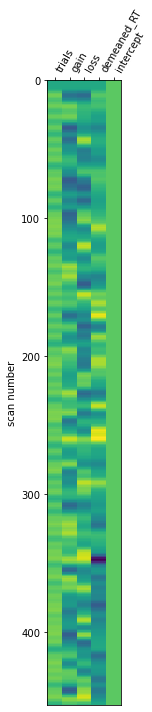

In [15]:
# Plot design matrix
plot_design_matrix(specs[0].X)

Finally, these are the contrasts for the root node:

The contrasts specify the outputs of the `Node` that will be passed to subsequent Nodes

In [16]:
# Contrast specification
first_run.contrasts

[ContrastInfo(name='loss', conditions=['loss'], weights=[1], test='t', entities={'run': 1, 'subject': '001', 'contrast': 'loss'}),
 ContrastInfo(name='trials', conditions=['trials'], weights=[1], test='t', entities={'run': 1, 'subject': '001', 'contrast': 'trials'}),
 ContrastInfo(name='gain', conditions=['gain'], weights=[1], test='t', entities={'run': 1, 'subject': '001', 'contrast': 'gain'})]

### Subject-level model

Now that we have populated the design matrices for the run-level root node `Node`, we can advance the graph to the next level, and repeat the process.

Here, the subsequent `Node` is a `subject` level fixed-effects meta-analysis model, which comibines run estimates, separately for each combination of `contrast` and `subject`.

In [17]:
next_node = root_node.children[0].destination

In [18]:
next_node.level

'subject'

In [19]:
next_node.group_by

['subject', 'contrast']

In order to populate the `subject` level node, we need to pass the outputs from the previous `run` level `Node` as inputs to the subsequent `Node`.

In [20]:
contrasts = list(chain(*[s.contrasts for s in specs]))

Since the `subject` level `Node` is `group_by` : `['subject', 'contrast']`, each combination of `subject` and `contrast` will have a separate `BIDSStatsModelsNodeOutput` object:

In [21]:
sub_specs = next_node.run(contrasts)
sub_specs

[<BIDSStatsModelsNodeOutput(level=subject, entities={'contrast': 'loss', 'subject': '001'})>,
 <BIDSStatsModelsNodeOutput(level=subject, entities={'contrast': 'trials', 'subject': '001'})>,
 <BIDSStatsModelsNodeOutput(level=subject, entities={'contrast': 'gain', 'subject': '001'})>,
 <BIDSStatsModelsNodeOutput(level=subject, entities={'contrast': 'loss', 'subject': '002'})>,
 <BIDSStatsModelsNodeOutput(level=subject, entities={'contrast': 'trials', 'subject': '002'})>,
 <BIDSStatsModelsNodeOutput(level=subject, entities={'contrast': 'gain', 'subject': '002'})>,
 <BIDSStatsModelsNodeOutput(level=subject, entities={'contrast': 'loss', 'subject': '003'})>,
 <BIDSStatsModelsNodeOutput(level=subject, entities={'contrast': 'trials', 'subject': '003'})>,
 <BIDSStatsModelsNodeOutput(level=subject, entities={'contrast': 'gain', 'subject': '003'})>]

Taking a look at a single Nodes's specification, the design matrix (`X`) is:

In [22]:
sub_specs[3].X

,intercept
0,1
1,1
2,1
3,1


In this case, we are applying a simple intercept model which is equivalent to a one-sample t-test.

To understand which inputs are associated with this design, we can look at the `metadata` attribute:

In [23]:
sub_specs[3].metadata

,contrast,run,subject
0,loss,1,002
1,loss,2,002
2,loss,3,002
3,loss,4,002


Finally the contrast for this `Node` simply passes forward the intercept:

In [24]:
sub_specs[3].contrasts

[ContrastInfo(name='loss', conditions=['intercept'], weights=[1], test='t', entities={'contrast': 'loss', 'subject': '002'})]

### Group-level Nodes

Remember that the group-level of this model, we defined three separate `Nodes`, each performing a different analysis.

- "positive" is a within-group one-sample t-test of all contrasts.

- "negative-loss" is a within-group one-sample t-test for the 'loss' contrast, but reversed such that the positive direction is negative.

- "between-groups" is a between-group comparison of the 'loss' contrast.

Let's take a look at each separately:

#### "Positive" Node (Within-Groups)

Let's look at the original definition of this `Node` and the corresponding `Edge` in the original JSON specification:

In [25]:
spec['Nodes'][3]

{'Level': 'Dataset',
 'Name': 'negative-loss',
 'GroupBy': ['contrast', 'group'],
 'Model': {'X': [1]},
 'Contrasts': [{'Name': 'negative',
   'ConditionList': [1],
   'Weights': [-1],
   'Test': 't'}]}

In [26]:
spec['Edges'][1]

{'Source': 'subject', 'Destination': 'positive'}

This `Node` specifies to run a separate one-sample t-test for each contrast, for each group separately (`'GroupBy': ['contrast', 'group']`)

In [27]:
# Prepare subject-level Node output contrasts
sub_contrasts = list(chain(*[s.contrasts for s in sub_specs]))

# Run "positive" Node
ds0_node = next_node.children[0].destination 
ds0_specs = ds0_node.run(sub_contrasts)

There are unique `BIDSStatsModelsNodeOutput` objects (and thus, models) for each contrast / group combiation:

In [28]:
ds0_specs

[<BIDSStatsModelsNodeOutput(level=positive, entities={'contrast': 'loss', 'group': 'equalIndifference'})>,
 <BIDSStatsModelsNodeOutput(level=positive, entities={'contrast': 'trials', 'group': 'equalIndifference'})>,
 <BIDSStatsModelsNodeOutput(level=positive, entities={'contrast': 'gain', 'group': 'equalIndifference'})>,
 <BIDSStatsModelsNodeOutput(level=positive, entities={'contrast': 'loss', 'group': 'equalRange'})>,
 <BIDSStatsModelsNodeOutput(level=positive, entities={'contrast': 'trials', 'group': 'equalRange'})>,
 <BIDSStatsModelsNodeOutput(level=positive, entities={'contrast': 'gain', 'group': 'equalRange'})>]

Taking a look at this first, we can see the model is a simple intercept model, which is equivalent to a one-sample t-test:

In [29]:
ds0_specs[0].X

,intercept
0,1
1,1


With the following inputs:

In [30]:
ds0_specs[0].metadata

,contrast,subject
0,loss,001
1,loss,003


#### "Negative-Loss" Node (Within-Groups)

Next, the "negative-loss" Node takes _only_ the 'loss' contrast, and reverses the sign of the positive direction, such that the positive direction is negative.

In the `Contrast` section of the model, we specify the weight as -1 to flip the sign.

In [31]:
# Negative-loss node specification
spec['Nodes'][4]

{'Level': 'Dataset',
 'Name': 'between-groups',
 'GroupBy': ['contrast'],
 'Model': {'X': [1, 'group'], 'Formula': '0 + C(group)'},
 'Contrasts': [{'Name': 'range_vs_indiference',
   'ConditionList': ['C(group)[T.equalRange]',
    'C(group)[T.equalIndifference]'],
   'Weights': [1, -1],
   'Test': 't'}]}

The corresponding `Edge` specifies to `Filter` the input to only include the 'loss' contrast:

In [32]:
spec['Edges'][3]

{'Source': 'subject',
 'Destination': 'between-groups',
 'Filter': {'contrast': ['loss']}}

In [33]:
ds1_node = next_node.children[1].destination
ds1_specs = ds1_node.run(sub_contrasts,**next_node.children[1].filter)

The design matrix for the group-level node peforms a simple one-sample t-test on the subject-level contrasts:

In [34]:
ds1_specs[0].X

,intercept
0,1
1,1


In [35]:
ds1_specs[0].metadata

,contrast,subject
0,loss,001
1,loss,003


Finally, looking at the contrasts, we can see that the 'loss' contrast is passed forward, but with the positive direction flipped:

In [36]:
ds1_specs[0].contrasts

[ContrastInfo(name='loss_negative', conditions=['intercept'], weights=[-1], test='t', entities={'contrast': 'loss_negative', 'group': 'equalIndifference'})]

### Between-Groups Node specification

Finally, the "between-groups" Node is a between-group comparison of the 'loss' contrast. 

Importantly, the `GroupBy` is set to `['contrast']`, such that the model is run separately for each contrast, but the contrasts are combined across groups.

In [37]:
spec['Nodes'][-1]

{'Level': 'Dataset',
 'Name': 'between-groups',
 'GroupBy': ['contrast'],
 'Model': {'X': [1, 'group'], 'Formula': '0 + C(group)'},
 'Contrasts': [{'Name': 'range_vs_indiference',
   'ConditionList': ['C(group)[T.equalRange]',
    'C(group)[T.equalIndifference]'],
   'Weights': [1, -1],
   'Test': 't'}]}

In addition, this `Node` uses `Formula` notation to specify the model. The `C(group)` term specifies a categorical variable, which will be used to specify the between-group comparison.

In the `Contrast` section, we can refer to specific levels of the categorical variable using the `C()` notation. Here, we specify a contrast of `C(group)[T.equalRange] - C(group)[T.equalIndifference]`, with weights `[1, -1]`.

As in the previous `Node`, the corresponding `Edge` specifies to `Filter` the input to only include the 'loss' contrast:

In [38]:
spec['Edges'][3]

{'Source': 'subject',
 'Destination': 'between-groups',
 'Filter': {'contrast': ['loss']}}

In [39]:
# Running between-subject Node
ds2_node = next_node.children[2].destination 
filters = next_node.children[2].filter or {}
print(filters)
ds2_specs = ds2_node.run(sub_contrasts, **filters)
print(ds2_specs)

{'contrast': ['loss']}
[<BIDSStatsModelsNodeOutput(level=between-groups, entities={'contrast': 'loss'})>]


The design matrix (`X`) for this `Node` contrasts subjects 1 and 3 vs 2, as these subjects differ by `group`:

In [40]:
ds2_specs[0].X

,C(group)[T.equalIndifference],C(group)[T.equalRange]
0,1,0
1,0,1
2,1,0


In [41]:
ds2_specs[0].metadata

,contrast,subject,suffix
0,loss,001,participants
1,loss,002,participants
2,loss,003,participants
